In [52]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares

from hw10_utils import draw_ellipse, get_points_and_transformation, get_ellipse

## Exercise 10 - Non-linear least-squares fitting

In this exercise we will apply the same ideas that we have explored in class to solve a geometrical problem: to find
a parametric description of a non-linear shape—an ellipsis—given noisy measurements of it.

### Problem

We want to estimate the parameters of an ellipse, given a number of points that lie approximately at its perimeter.

### General approach
- Find a transformation that maps points from ellipse to unit circle
- Minimize euclidean distance from points to unit circle
- Apply inverse transformation

## Data Generation and Visualization

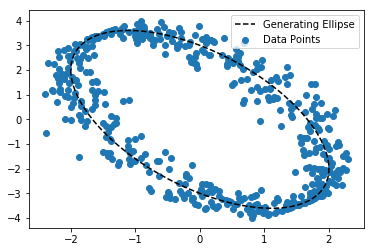

In [53]:
# Plot the noisy data
# noisy_ellipse, B = get_points_and_transformation()
noisy_ellipse = np.load('ellipse_datapoints.npy')
plt.scatter(noisy_ellipse[:, 0], noisy_ellipse[:, 1], label='Data Points')

# Plot the original ellipse from which the data was generated
ground_truth_ellipse = get_ellipse(B)
plt.plot(ground_truth_ellipse[:,0], ground_truth_ellipse[:,1], 'k--', label='Generating Ellipse')
plt.legend();

In [54]:
# Augment (x,y) to (x,y,1)
S = noisy_ellipse.T
S = np.vstack((S, np.ones((1,S.shape[1]))))

## Non-linear Least Square Optimization for Ellipse Fitting

Algebraic distance to ellipse is defined as below, however, it can not be used for non-linear least square optimization. We define Euclidean distance to ellipse and minimize geometric loss with non-linear least square optimization for regression.

\begin{align}
\vec{u}^{C} = [u_{i}, v_{i}, 1]^{T}
\end{align}

\begin{align}
d_{a}(X,\vec{u}^{C}) = au_{i}^2 + bu_{i}v_{i} + cv_{i}^2 + du_{i} + ev_{i} + f
\end{align}

Affine transformation $T_{a}^{-1}$ that maps data points on ellipse to unit circle is defined as;

\begin{align}
T_{a}^{-1} = \left[ {\begin{array}{cc}
   t_{1} & t_{2} & t_{3} \\
   t_{4} & t_{5} & t_{6} \\
   0 & 0 & 1 \\
  \end{array} } \right]
\end{align}

Our model parameters,  $X = [t_{1}, t_{2}, t_{3}, t_{4}, t_{5}, t_{6}]$ and we optimize over these parameters to find transformation $T_{a}$ and finally fitting ellipse.

Data point $\vec{u}$ is defined is as follows;
\begin{align}
\vec{u} = [x, y, 1]^{T}
\end{align}

\begin{align}
\vec{u}_{a} = T_{a}^{-1}\vec{u} = [u_{a}, v_{a}, 1]
\end{align}

\begin{align}
\vec{u}_{a}^{C} = [u_{a}, v_{a}, \sqrt{u_{a}^2 + v_{a}^2}]
\end{align}

We define;
\begin{align}
C = \sqrt{u_{a}^2 + v_{a}^2} = \sqrt{(t_{1}x + t_{2}y + t_{3})^2 + (t_{4}x + t_{5}y + t_{6})^2}
\end{align}

Euclidean distance to ellipse is as follows;
\begin{align}
d_{e}(X,\vec{u}_{a}) = d_{e}(\vec{u}_{a}^{C}, \vec{u}_{a}) = \sqrt{u_{a}^2 + v_{a}^2} - 1 = C - 1
\end{align}

Jacobian, $J$, for model parameters $X$ is defined as follows;

\begin{align}
J = \left[ {\begin{array}{cc}
   \frac{\partial d_{e}(X,{}_{1}\vec{u}_{a})}{\partial t_{1}} & \frac{\partial d_{e}(X,{}_{1}\vec{u}_{a})}{\partial t_{2}} & ... & \frac{\partial d_{e}(X,{}_{1}\vec{u}_{a})}{\partial t_{6}} \\
   \frac{\partial d_{e}(X,{}_{2}\vec{u}_{a})}{\partial t_{1}} & \frac{\partial d_{e}(X,{}_{2}\vec{u}_{a})}{\partial t_{2}} & ... & \frac{\partial d_{e}(X,{}_{2}\vec{u}_{a})}{\partial t_{6}} \\
   . & . & ... & . \\
   \frac{\partial d_{e}(X,{}_{n}\vec{u}_{a})}{\partial t_{1}} & \frac{\partial d_{e}(X,{}_{n}\vec{u}_{a})}{\partial t_{2}} & ... & \frac{\partial d_{e}(X,{}_{n}\vec{u}_{a})}{\partial t_{6}} \\
  \end{array} } \right]_{N x 6}
\end{align}

\begin{align}
\frac{\partial d_{e}(X,{}_{1}\vec{u}_{a})}{\partial X} = \frac{\partial C_{1}}{\partial X} 
\end{align}

\begin{align}
\frac{\partial C_{1}}{\partial t_{1}} =\frac{1}{C_{1}} (t_{1}x + t_{2}y + t_{3}) x
\end{align}

\begin{align}
\frac{\partial C_{1}}{\partial t_{2}} =\frac{1}{C_{1}} (t_{1}x + t_{2}y + t_{3}) y
\end{align}

In [55]:
# S = (3, N)
# Ta = (6,)
def calculate_C(Ta, S):
    Ta = Ta.reshape((2,3))
    return np.sqrt(np.sum(((Ta @ S))**2, axis=0))

# return residual = (N, )
def calculate_residual(Ta, S):
    C = calculate_C(Ta, S)
    return C - 1

# return J = (N, 6)
def calculate_jacobian(Ta, S):
    C = calculate_C(Ta, S)
    Ta = np.vstack((Ta.reshape((2,3)),np.array([0,0,1])))
    J = ((Ta @ S)[:,np.newaxis,:] * S[np.newaxis,:,:]) / C
    J = J.reshape((-1,J.shape[-1]))[:6].T 
    return J

## 1. Levenberg-Marquardt Method

Using scipy.least_square for non-linear optimation with defined residual and jacobian functions

In [56]:
x0 = np.arange(6)
x1 = least_squares(calculate_residual, x0, calculate_jacobian, args=([S]))
Ta = np.vstack(((x1.x).reshape(2,3), np.array([0,0,1])))
print(Ta)

[[-0.52804544 -0.04143024 -0.00390522]
 [ 0.22198796  0.32304239  0.00869479]
 [ 0.          0.          1.        ]]


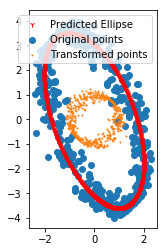

In [57]:
draw_ellipse(S, Ta)

Implement Levenberg-Marquardt optimization step using calculate_residual and calculate_jacobian functions

\begin{align}
F(X) = [d_{e}(X,{}_{1}\vec{u}_{a}), d_{e}(X,{}_{2}\vec{u}_{a}), ..., d_{e}(X,{}_{n}\vec{u}_{a})]
\end{align}

\begin{align}
(J^TJ+\lambda I)dX &= -J^TF(X)
\end{align}

In [58]:
# L1-norm
def norm(v):
    return np.sum(np.abs(v))

def compute_LVMstep(X, S, lmbda):
    F = calculate_residual(X, S)
    J = calculate_jacobian(X, S)
    
    print(np.sum(F))
    for i in range(40):
        dX = np.linalg.solve(J.T@J + np.eye(J.shape[1]) * lmbda, J.T@F)
        newF = calculate_residual(X-dX, S)
        
        if norm(newF) < norm(F):
            lmbda = lmbda / 10
            return (-dX, lmbda)
        else:
            lmbda = lmbda * 10
    return None

def fit_LVM(X, S):
    lmbda = 0.001
    
    for i in range(100):
        update = compute_LVMstep(X, S, lmbda)
        if update is not None:
            X = X + update[0]
            lmbda = update[1]
        else:
            print("Optimization converged")
            return X
    return X

In [59]:
x2 = fit_LVM(x0, S)

3966.300555977933
290.7063266265559
22.498041123960604
-7.024457106916617
-7.867267215069804
-7.86892135858826
-7.8689223291186
-7.868922331162766
-7.868922226880027
-7.868922316350818
-7.868922329710511
-7.868922331434751
-7.868922331453261
-7.8689223314723575
-7.868922331472395
-7.868922331472661
Optimization converged


In [60]:
Ta = np.vstack((x2.reshape(2,3), np.array([0,0,1])))
print(Ta)

[[-3.78765752e-01  1.03317021e-01  2.68905153e-04]
 [ 4.29705163e-01  3.08866065e-01  9.52773257e-03]
 [ 0.00000000e+00  0.00000000e+00  1.00000000e+00]]


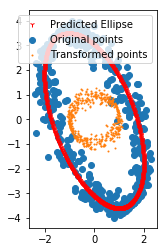

In [61]:
draw_ellipse(S, Ta)

## 2. Gradient Descent

The gradient descent optimization algorithm uses the residuals at each timestep's prediction to compute a new, better estimate of the parameters.

The residuals, in this problem, are given by the squared euclidean distances between the data points and points lying on the actual ellipse that we want to find:

$$
\mathbf{F}(\mathbf{X}) = \sum_i d(x_i, \mathbf{X})^2
$$

The Gradient Descent algorithm estimates via partial derivatives how those residuals change. The gradient is given by:

$$
\nabla \mathbf{F}(\mathbf{X}) =
\left[
\begin{matrix} 
\frac {\partial \mathbf{F}} {\partial X_1} 
\ldots
\frac {\partial \mathbf{F}} {\partial X_n}
\end{matrix}
\right]
$$

The update rule is hence simply taking a small step, given by a learning rate $\lambda$, in the opposite direction of the gradient, or

$$
\mathbf{X}^{t+1} = \mathbf{X}^{t} - \lambda \nabla \mathbf{F}(\mathbf{X^t})
$$

In [62]:
def calculate_gradient(Ta, S):
    d = calculate_residual(Ta, S) 
    J = calculate_jacobian(Ta, S)

    return 2 * np.sum(d[:,np.newaxis] * J, axis=0)

def fit_GD(Ta, S):
    lmbda = 0.0002
    
    for i in range(100):
        grad = calculate_gradient(Ta, S)
        Ta = Ta - lmbda * grad
        
        if i % 10 == 1:
            print("Loss: ", np.sum(calculate_residual(Ta, S)**2))
    return Ta

In [63]:
x0 = np.random.uniform(0,1,6) 
x3 = fit_GD(x0, S)

Loss:  149.03718261630885
Loss:  17.699133353967593
Loss:  9.130653323263386
Loss:  8.04172151578993
Loss:  7.892833661822673
Loss:  7.872250233208268
Loss:  7.86938805059113
Loss:  7.868987848342282
Loss:  7.868931592925501
Loss:  7.8689236463909324


In [64]:
Ta = np.vstack((x3.reshape(2,3), np.array([0,0,1])))
print(Ta)

[[ 0.29081962  0.32567962  0.00915327]
 [ 0.49349006 -0.00228139  0.00273538]
 [ 0.          0.          1.        ]]


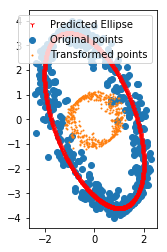

In [65]:
draw_ellipse(S, Ta)